# 1. Data Understanding

Load all the modules needed in this analysis.

In [1]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [2]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 14.4 MB/s 


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [4]:
# import sales dataset
data = pd.read_csv('/content/drive/MyDrive/RG CAMP/Final Project - 113/Dataset Final Project/Sales/sales1.csv')

In [5]:
# see sales dataset dimension
data.shape
print('Dataframe dimensions:', data.shape)

Dataframe dimensions: (180508, 15)


sales dataset contains 180.508 rows and 12 columns.

In [6]:
# take a look at first five rows of sales dataset
data.head()

,order_id,user_id,product_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,num_of_item,cost,category,name,brand
0,44006,35515,13606,Complete,2021-01-21 04:56:58,2021-01-19 07:16:00,2021-01-22 03:38:00,NaN,2.5,F,3,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc
1,59418,47846,13606,Cancelled,2022-05-22 11:36:45,NaN,NaN,NaN,2.5,F,2,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc
2,27384,22099,28951,Shipped,2022-02-12 14:40:47,2022-02-15 04:48:00,NaN,NaN,3.0,M,4,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades
3,98658,79128,28951,Returned,2021-11-02 02:32:52,2021-11-02 12:34:00,2021-11-06 20:31:00,2021-11-07 19:31:00,3.0,M,2,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades
4,105326,84559,28951,Returned,2021-10-12 07:11:30,2021-10-13 00:10:00,2021-10-14 01:20:00,2021-10-16 02:38:00,3.0,M,3,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      180508 non-null  int64  
 1   user_id       180508 non-null  int64  
 2   product_id    180508 non-null  int64  
 3   status        180508 non-null  object 
 4   created_at    180508 non-null  object 
 5   shipped_at    117502 non-null  object 
 6   delivered_at  63035 non-null   object 
 7   returned_at   17752 non-null   object 
 8   sale_price    180508 non-null  float64
 9   gender        180508 non-null  object 
 10  num_of_item   180508 non-null  int64  
 11  cost          180508 non-null  float64
 12  category      180508 non-null  object 
 13  name          180496 non-null  object 
 14  brand         180365 non-null  object 
dtypes: float64(2), int64(4), object(9)
memory usage: 20.7+ MB


In [8]:
# convert shipped_at, delivered_at, and returned_at into datetime
data['shipped_at'] = pd.to_datetime(data['shipped_at'])
data['delivered_at'] = pd.to_datetime(data['delivered_at'])
data['returned_at'] = pd.to_datetime(data['returned_at'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      180508 non-null  int64         
 1   user_id       180508 non-null  int64         
 2   product_id    180508 non-null  int64         
 3   status        180508 non-null  object        
 4   created_at    180508 non-null  object        
 5   shipped_at    117502 non-null  datetime64[ns]
 6   delivered_at  63035 non-null   datetime64[ns]
 7   returned_at   17752 non-null   datetime64[ns]
 8   sale_price    180508 non-null  float64       
 9   gender        180508 non-null  object        
 10  num_of_item   180508 non-null  int64         
 11  cost          180508 non-null  float64       
 12  category      180508 non-null  object        
 13  name          180496 non-null  object        
 14  brand         180365 non-null  object        
dtypes: datetime64[ns]

In [10]:
data.describe()

,order_id,user_id,product_id,sale_price,num_of_item,cost
count,180508.000000,180508.000000,180508.000000,180508.000000,180508.000000,180508.000000
mean,62408.024420,50171.351602,15290.370105,59.799867,1.894021,28.754903
std,35991.857094,28839.688216,8405.434843,65.844662,1.058109,30.628474
min,1.000000,1.000000,1.000000,0.020000,1.000000,0.008300
25%,31249.750000,25249.750000,8050.000000,24.900000,1.000000,11.400000
50%,62520.000000,50273.000000,16029.000000,39.990002,2.000000,19.955011
75%,93647.000000,75175.000000,22547.000000,69.949997,2.000000,34.715039
max,124512.000000,100000.000000,29120.000000,999.000000,4.000000,557.151002


In [11]:
data.describe()

,order_id,user_id,product_id,sale_price,num_of_item,cost
count,180508.000000,180508.000000,180508.000000,180508.000000,180508.000000,180508.000000
mean,62408.024420,50171.351602,15290.370105,59.799867,1.894021,28.754903
std,35991.857094,28839.688216,8405.434843,65.844662,1.058109,30.628474
min,1.000000,1.000000,1.000000,0.020000,1.000000,0.008300
25%,31249.750000,25249.750000,8050.000000,24.900000,1.000000,11.400000
50%,62520.000000,50273.000000,16029.000000,39.990002,2.000000,19.955011
75%,93647.000000,75175.000000,22547.000000,69.949997,2.000000,34.715039
max,124512.000000,100000.000000,29120.000000,999.000000,4.000000,557.151002


In [12]:
data.head().sort_values('order_id')

,order_id,user_id,product_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,num_of_item,cost,category,name,brand
2,27384,22099,28951,Shipped,2022-02-12 14:40:47,2022-02-15 04:48:00,NaT,NaT,3.0,M,4,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades
0,44006,35515,13606,Complete,2021-01-21 04:56:58,2021-01-19 07:16:00,2021-01-22 03:38:00,NaT,2.5,F,3,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc
1,59418,47846,13606,Cancelled,2022-05-22 11:36:45,NaT,NaT,NaT,2.5,F,2,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc
3,98658,79128,28951,Returned,2021-11-02 02:32:52,2021-11-02 12:34:00,2021-11-06 20:31:00,2021-11-07 19:31:00,3.0,M,2,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades
4,105326,84559,28951,Returned,2021-10-12 07:11:30,2021-10-13 00:10:00,2021-10-14 01:20:00,2021-10-16 02:38:00,3.0,M,3,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades


In [13]:
# take a look at each column type and number of null values
data_info = pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
data_info = data_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values in number'}))
data_info = data_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'null values in percent'}))
data_info

,order_id,user_id,product_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,num_of_item,cost,category,name,brand
column type,int64,int64,int64,object,object,datetime64[ns],datetime64[ns],datetime64[ns],float64,object,int64,float64,object,object,object
null values in number,0,0,0,0,0,63006,117473,162756,0,0,0,0,0,12,143
null values in percent,0.0,0.0,0.0,0.0,0.0,34.904824,65.07911,90.165533,0.0,0.0,0.0,0.0,0.0,0.006648,0.079221


from data_info above, we can see that:
*   shipped_at contains 34.9% null values
*   delivered_at contains 65% null values
*   returned_at 90% null values
*   name contains 12 null values
*   brand contains 143 null values

In [14]:
# Replace NaN with 0
data['shipped_at'] = data['shipped_at'].fillna(0)
data['delivered_at'] = data['delivered_at'].fillna(0)
data['returned_at'] = data['returned_at'].fillna(0)

# Delete null values in brand and name 
data = data.dropna(axis=0)

In [15]:
# Check again data info and null values
# take a look at each column type and number of null values
data.isnull().sum()

order_id        0
user_id         0
product_id      0
status          0
created_at      0
shipped_at      0
delivered_at    0
returned_at     0
sale_price      0
gender          0
num_of_item     0
cost            0
category        0
name            0
brand           0
dtype: int64

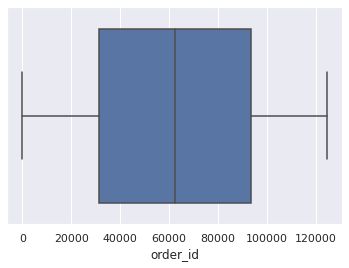

In [16]:
sns.boxplot(data['order_id'])

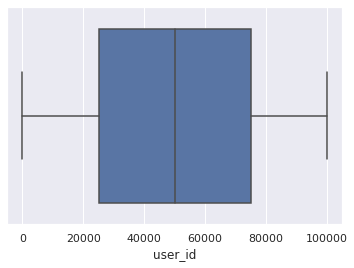

In [17]:
sns.boxplot(data['user_id'])

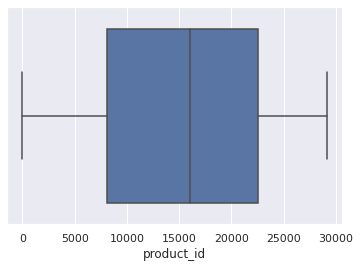

In [18]:
sns.boxplot(data['product_id'])

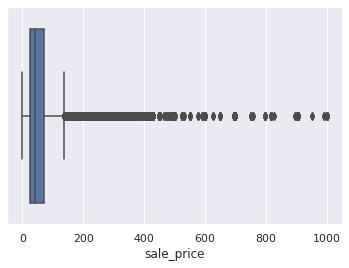

In [19]:
sns.boxplot(data['sale_price'])

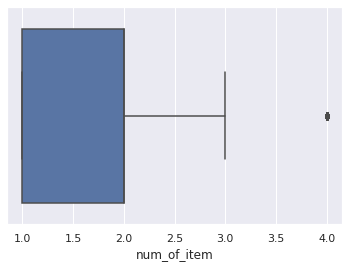

In [20]:
sns.boxplot(data['num_of_item'])

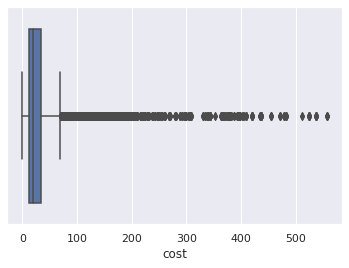

In [21]:
sns.boxplot(data['cost'])

### Add New Columns

In [22]:
# Add total_revenue column
data['total_revenue'] = data['sale_price'] * data['num_of_item']

# Add total_cost column
data['total_costs'] = data['cost'] * data['num_of_item']

# Add revenue column
data['profit'] = data['total_revenue'] - data['total_costs']

In [23]:
data.head()

,order_id,user_id,product_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,num_of_item,cost,category,name,brand,total_revenue,total_costs,profit
0,44006,35515,13606,Complete,2021-01-21 04:56:58,2021-01-19 07:16:00,2021-01-22 03:38:00,0,2.5,F,3,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,7.5,3.3225,4.1775
1,59418,47846,13606,Cancelled,2022-05-22 11:36:45,0,0,0,2.5,F,2,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,5.0,2.2150,2.7850
2,27384,22099,28951,Shipped,2022-02-12 14:40:47,2022-02-15 04:48:00,0,0,3.0,M,4,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,12.0,5.0760,6.9240
3,98658,79128,28951,Returned,2021-11-02 02:32:52,2021-11-02 12:34:00,2021-11-06 20:31:00,2021-11-07 19:31:00,3.0,M,2,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,6.0,2.5380,3.4620
4,105326,84559,28951,Returned,2021-10-12 07:11:30,2021-10-13 00:10:00,2021-10-14 01:20:00,2021-10-16 02:38:00,3.0,M,3,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,9.0,3.8070,5.1930


In [24]:
data.describe()

,order_id,user_id,product_id,sale_price,num_of_item,cost,total_revenue,total_costs,profit
count,180353.000000,180353.000000,180353.000000,180353.000000,180353.000000,180353.000000,180353.000000,180353.000000,180353.000000
mean,62406.597362,50170.203590,15288.692653,59.820343,1.894063,28.764079,113.355673,54.497972,58.857701
std,35990.299524,28838.435353,8406.154020,65.863945,1.058127,30.637639,155.827885,72.682654,85.137991
min,1.000000,1.000000,1.000000,0.020000,1.000000,0.008300,0.020000,0.008300,0.011700
25%,31253.000000,25251.000000,8046.000000,24.900000,1.000000,11.400000,34.000000,16.454000,16.933950
50%,62522.000000,50275.000000,16028.000000,39.990002,2.000000,19.965000,65.800003,32.085298,32.942579
75%,93640.000000,75172.000000,22546.000000,69.949997,2.000000,34.724998,133.000000,64.495702,67.791242
max,124512.000000,100000.000000,29120.000000,999.000000,4.000000,557.151002,3996.000000,2149.140006,2377.619995


# 2. Data Preparation

### First, take a look at correlation of each variable

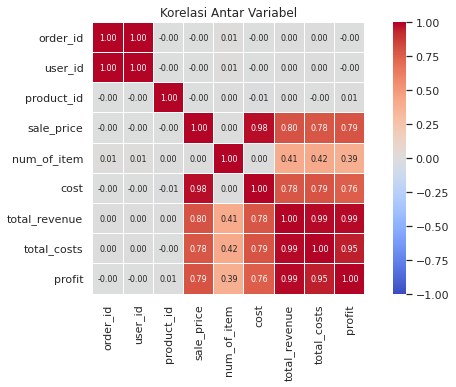

In [25]:
corr = data.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = "coolwarm", annot=True, annot_kws={"size":8}, fmt='.2f', linewidths=0.1, square = True)
plt.title("Korelasi Antar Variabel")
plt.show()

### How long is the period in days?

In [26]:
print("Datafile starts with timepoint {}".format(data.created_at.min()))
print("Datafile ends with timepoint {}".format(data.created_at.max()))

Datafile starts with timepoint 2019-01-05 05:39:08
Datafile ends with timepoint 2022-06-06 18:17:03.965896


### How many different order, user, and product do we have?

In [27]:
# unique order
n_order = data['order_id'].nunique()
print('Number of order placed in The Look:', n_order, 'out of 180.508 rows')

# Unique user
n_user = data['user_id'].nunique()
print('Number of user placed an order or orders in The Look:', n_user, 'out of 180.508 rows')

# Unique product
n_product = data['product_id'].nunique()
print('Number of product in The Look:', n_product, 'out of 180.508 rows')

Number of order placed in The Look: 124434 out of 180.508 rows
Number of user placed an order or orders in The Look: 79955 out of 180.508 rows
Number of product in The Look: 29025 out of 180.508 rows


From above, we can conclude that:
1. 1 user_id, could place more than 1 order_id
2. 1 order_id, could place more than 1 product_id
3. 1 order_id, could be created by user at different times
4. Every order_id have 1 status



### Which user are most common?

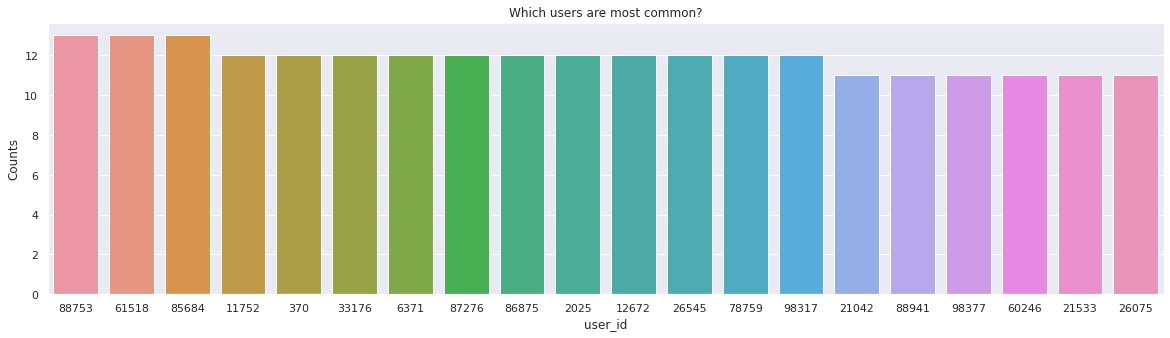

In [28]:
user_id_counts = data.user_id.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(user_id_counts.index, user_id_counts.values, order=user_id_counts.index)
plt.ylabel("Counts")
plt.xlabel("user_id")
plt.title("Which users are most common?");
#plt.xticks(rotation=90);

### Which product_id are most common?

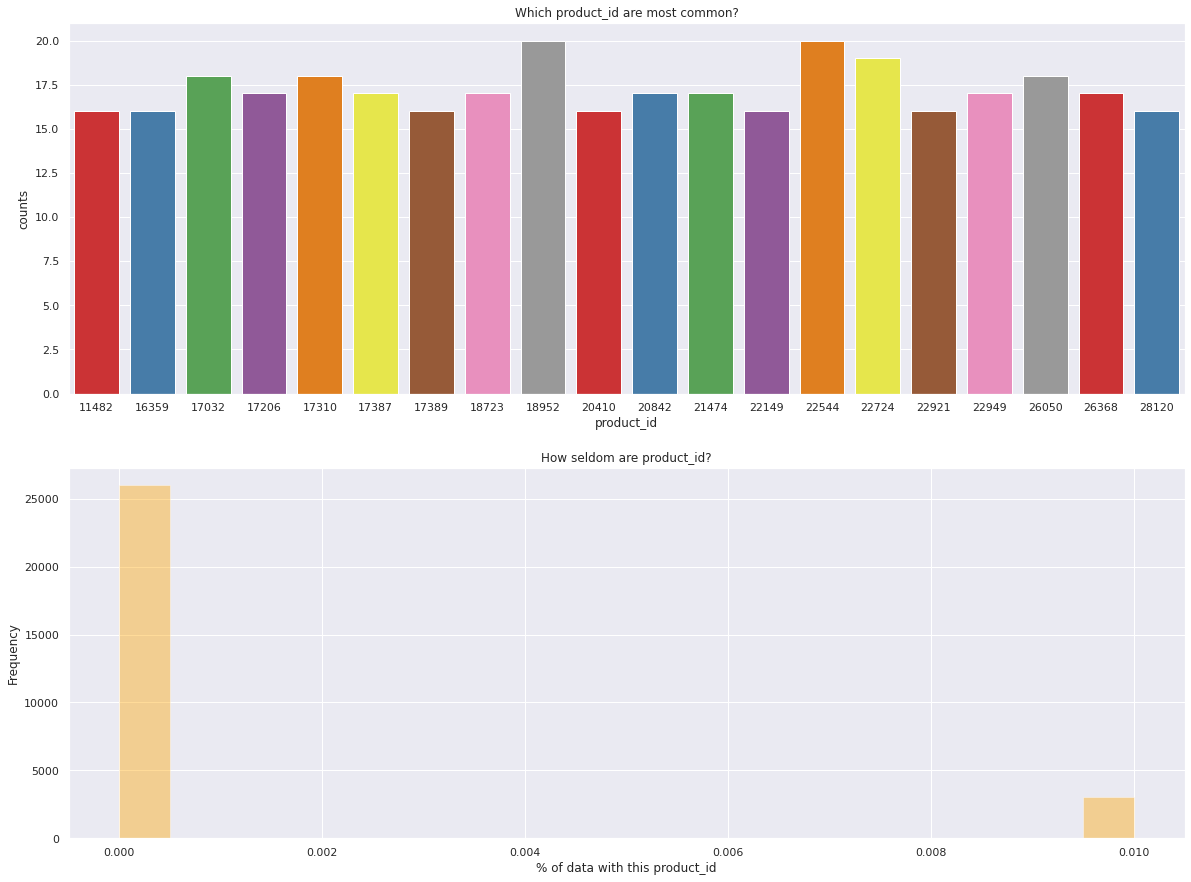

In [30]:
product_id_counts = data.product_id.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(product_id_counts.iloc[0:20].index,
            product_id_counts.iloc[0:20].values,
            ax = ax[0], palette="Set1")
ax[0].set_ylabel("counts")
ax[0].set_xlabel("product_id")
ax[0].set_title("Which product_id are most common?");
sns.distplot(np.round(product_id_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are product_id?")
ax[1].set_xlabel("% of data with this product_id")
ax[1].set_ylabel("Frequency");

### How many status do we have?

In [31]:
# Status in The Look 
n_status = data['status'].nunique()
print('There is', n_status, 'status in The Look sales processing. It contains:', pd.unique(data['status']))

There is 5 status in The Look sales processing. It contains: ['Complete' 'Cancelled' 'Shipped' 'Returned' 'Processing']


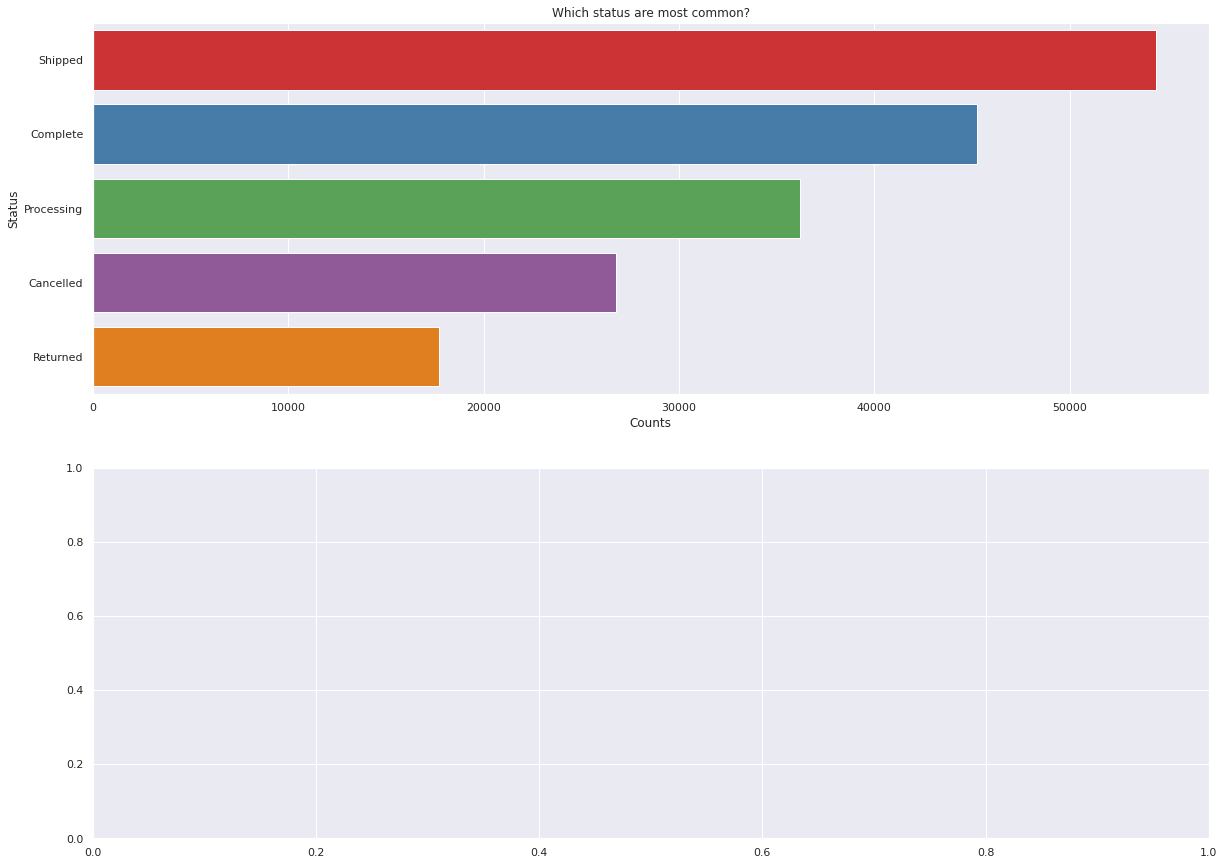

In [32]:
status_counts = data.status.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(status_counts.iloc[0:20].values,
            status_counts.iloc[0:20].index,
            ax = ax[0], palette="Set1")
ax[0].set_ylabel("Status")
ax[0].set_xlabel("Counts")
ax[0].set_title("Which status are most common?");

### How various the sale price?


In [33]:
# How many item could in a row?
max_sale_price = max(data['sale_price'])
print('The most expensive price of products is:', max_sale_price)

# The least amount of item could in a row?
min_sale_price = min(data['sale_price'])
print('The mcheapest price of product is:', min_sale_price)

The most expensive price of products is: 999.0
The mcheapest price of product is: 0.0199999995529651


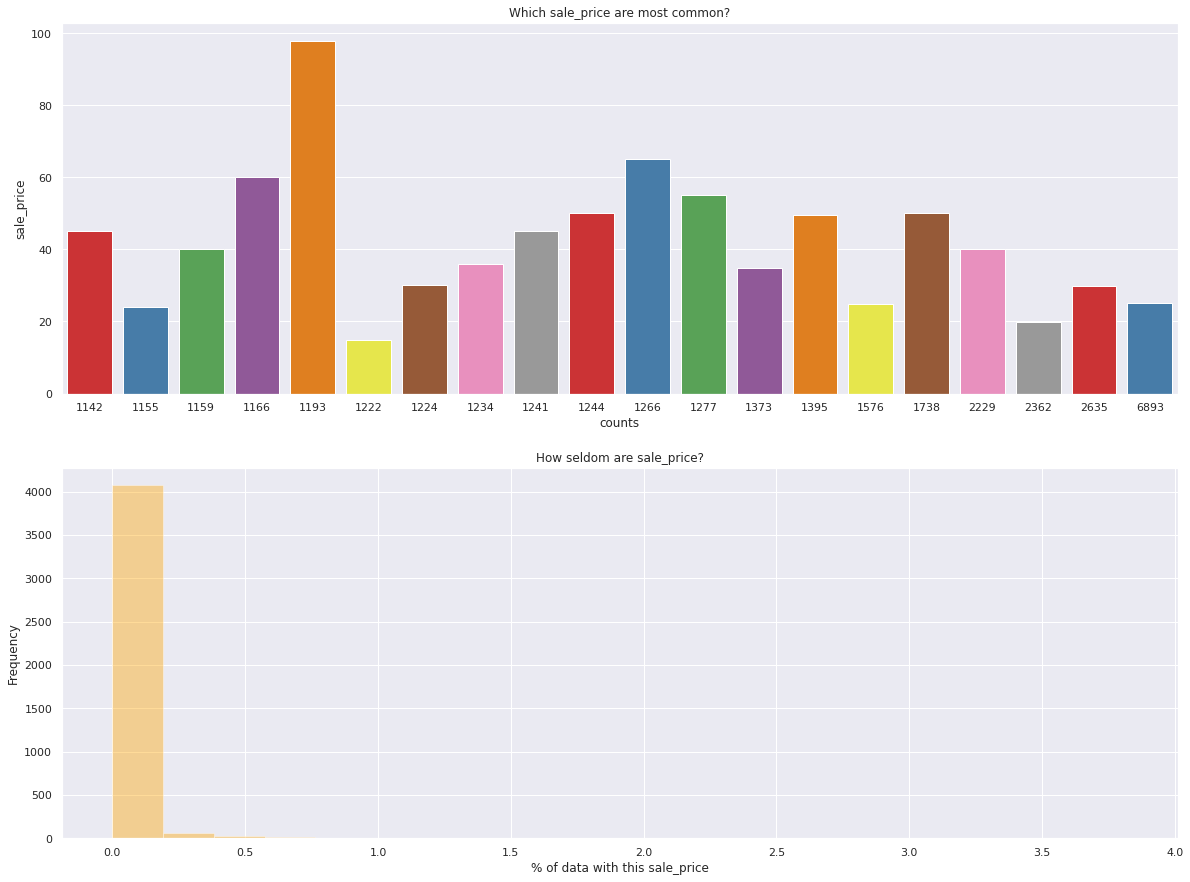

In [36]:
sale_price_counts = data.sale_price.value_counts().sort_values(ascending=False).T
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(sale_price_counts.iloc[0:20].values,
            sale_price_counts.iloc[0:20].index,
            ax = ax[0], palette="Set1")
ax[0].set_ylabel("sale_price")
ax[0].set_xlabel("counts")
ax[0].set_title("Which sale_price are most common?");
sns.distplot(np.round(sale_price_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are sale_price?")
ax[1].set_xlabel("% of data with this sale_price")
ax[1].set_ylabel("Frequency");

### How many gender do we have?

In [37]:
# Gender in The Look
n_gender = data['gender'].nunique()
print('There is', n_gender, 'gender in The Look sales processing. It contains:', pd.unique(data['gender']))

There is 2 gender in The Look sales processing. It contains: ['F' 'M']


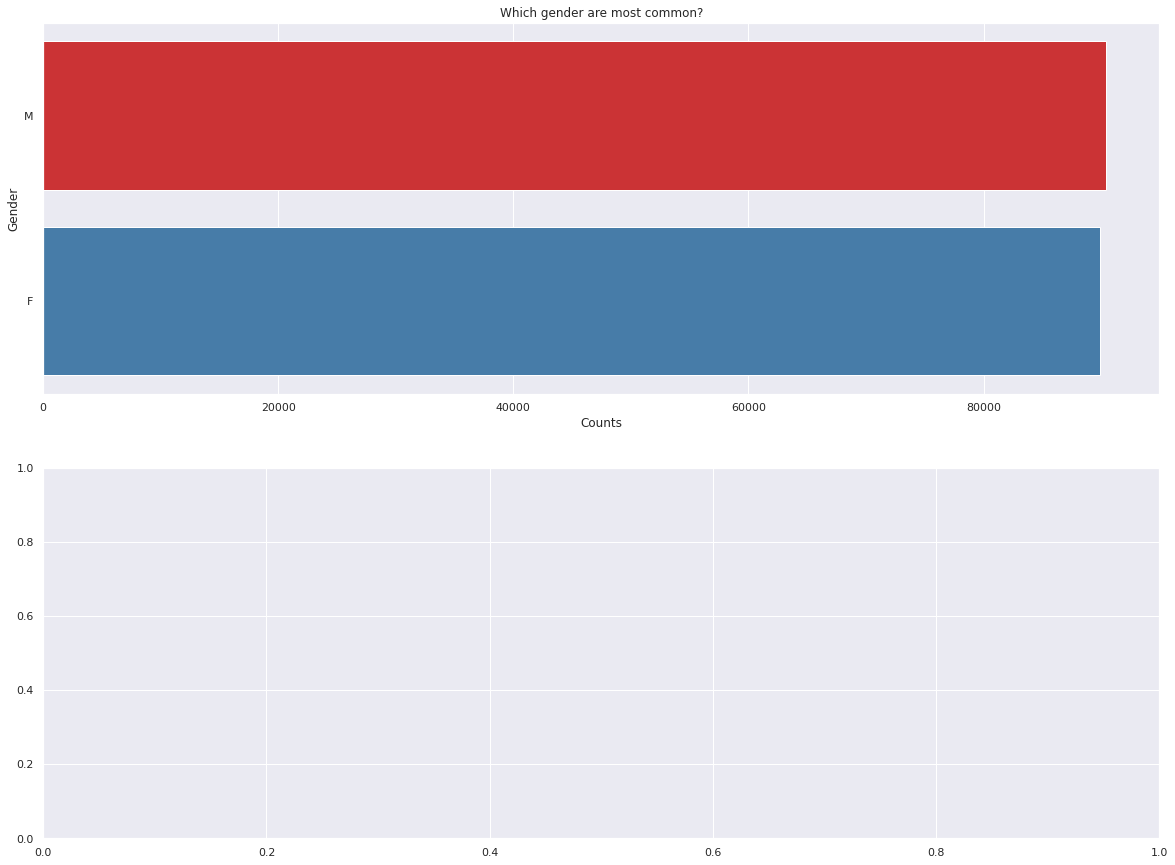

In [38]:
gender_counts = data.gender.value_counts().sort_values(ascending=False).T
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(gender_counts.iloc[0:20].values,
            gender_counts.iloc[0:20].index,
            ax = ax[0], palette="Set1")
ax[0].set_ylabel("Gender")
ax[0].set_xlabel("Counts")
ax[0].set_title("Which gender are most common?");

### How many number of item, user do usually buy?

In [39]:
n_num_of_item = data['num_of_item'].nunique()
print('There is', n_num_of_item, 'number of number of item in The Look sales processing.')

There is 4 number of number of item in The Look sales processing.


### Max and Min Number of Item

In [40]:
# Max Number of Item
max_num_of_item = max(data['num_of_item'])
print('The highest number of item in a row is:', max_num_of_item)

# Min Number of Item
min_num_of_item = min(data['num_of_item'])
print('The least number of item in a row is:', min_num_of_item)

The highest number of item in a row is: 4
The least number of item in a row is: 1


### Max and Min Cost of Product

In [41]:
# Max Cost of Product
max_cost = max(data['cost'])
print('The most expensive cost of products is:', max_cost)

# Min Cost of Product
min_cost = min(data['cost'])
print('The most cheapest cost of product is:', min_cost)

The most expensive cost of products is: 557.1510021798313
The most cheapest cost of product is: 0.0082999997779726


### Which category is the most common among user?

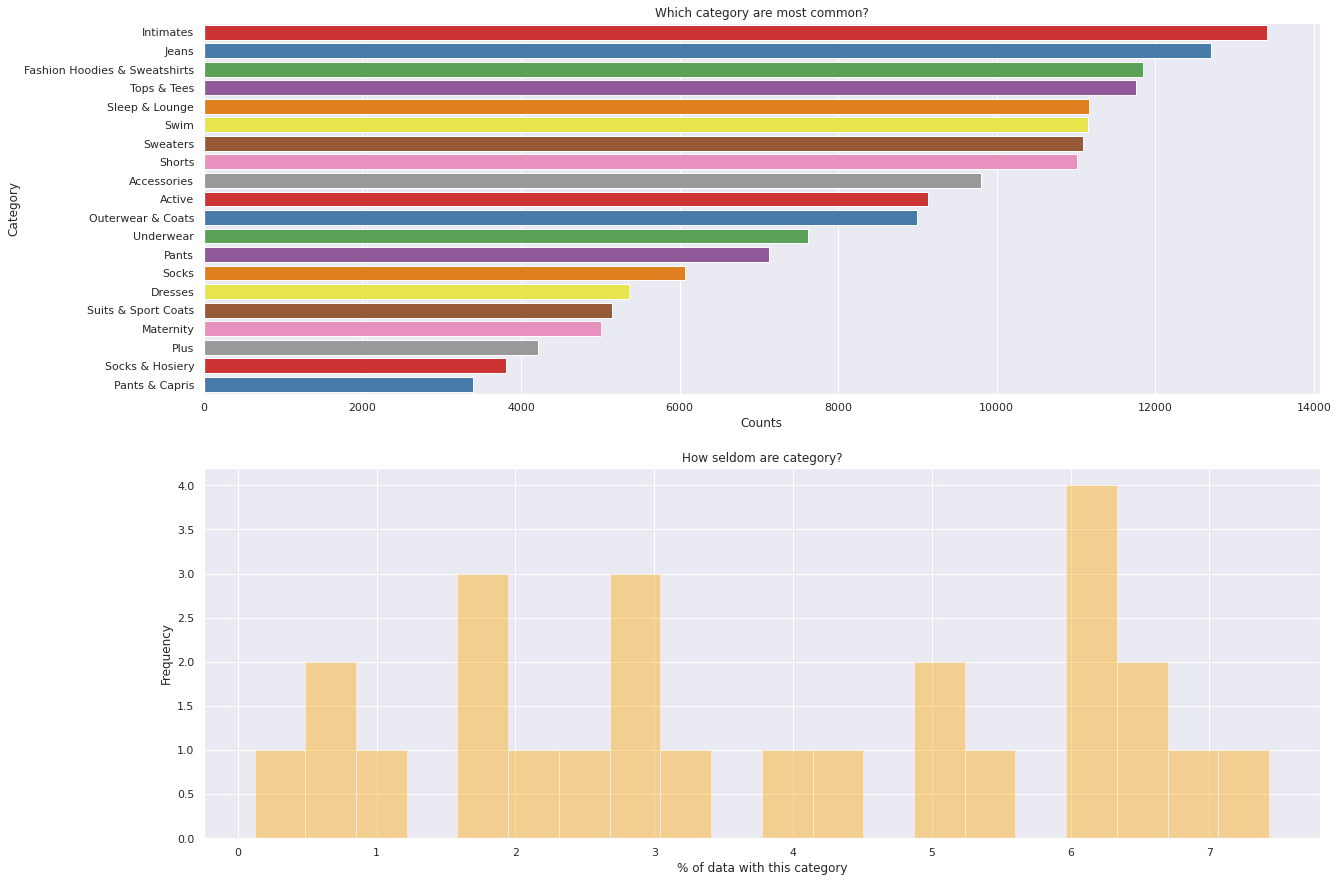

In [42]:
category_counts = data.category.value_counts().sort_values(ascending=False).T
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(category_counts.iloc[0:20].values,
            category_counts.iloc[0:20].index,
            ax = ax[0], palette="Set1")
ax[0].set_ylabel("Category")
ax[0].set_xlabel("Counts")
ax[0].set_title("Which category are most common?");
sns.distplot(np.round(category_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are category?")
ax[1].set_xlabel("% of data with this category")
ax[1].set_ylabel("Frequency");

### Which brand is the most common among user?

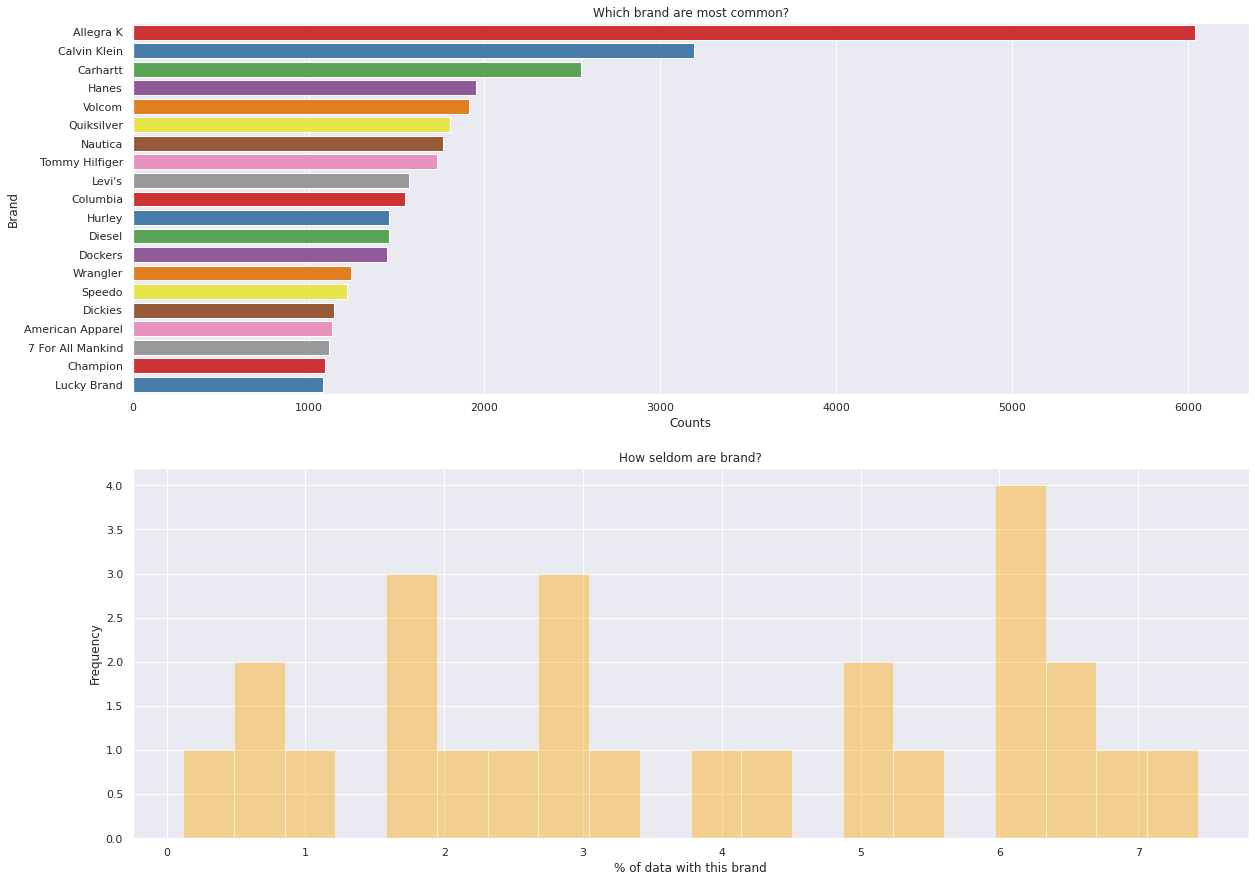

In [43]:
brand_counts = data.brand.value_counts().sort_values(ascending=False).T
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(brand_counts.iloc[0:20].values,
            brand_counts.iloc[0:20].index,
            ax = ax[0], palette="Set1")
ax[0].set_ylabel("Brand")
ax[0].set_xlabel("Counts")
ax[0].set_title("Which brand are most common?");
sns.distplot(np.round(category_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are brand?")
ax[1].set_xlabel("% of data with this brand")
ax[1].set_ylabel("Frequency");

### Which name is the most common among user?

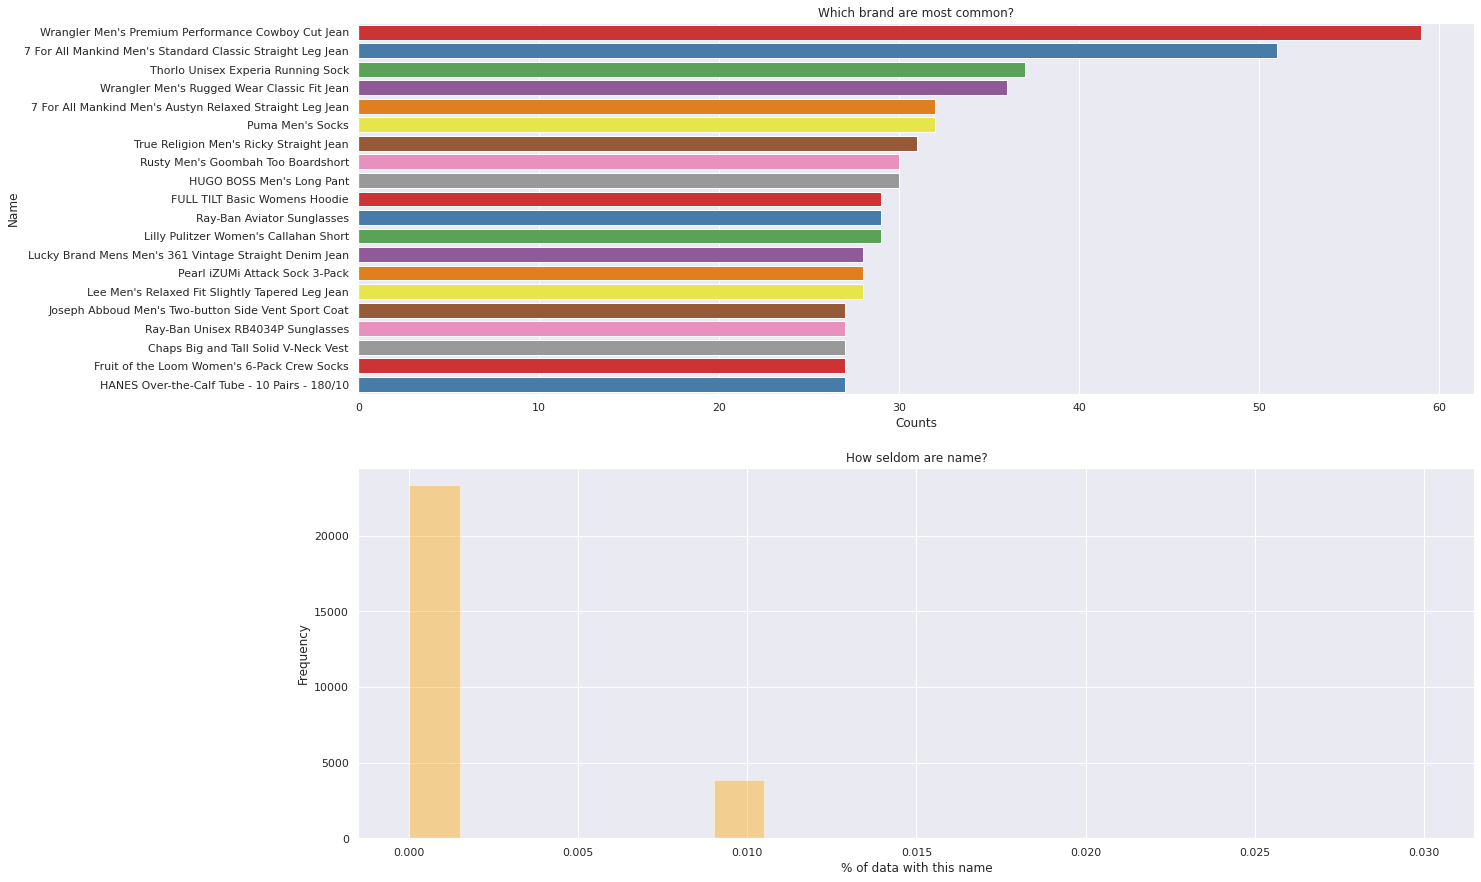

In [44]:
name_counts = data.name.value_counts().sort_values(ascending=False).T
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(name_counts.iloc[0:20].values,
            name_counts.iloc[0:20].index,
            ax = ax[0], palette="Set1")
ax[0].set_ylabel("Name")
ax[0].set_xlabel("Counts")
ax[0].set_title("Which brand are most common?");
sns.distplot(np.round(name_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are name?")
ax[1].set_xlabel("% of data with this name")
ax[1].set_ylabel("Frequency");

### Highest and Lowest Profit

In [45]:
# Highest Profit
max_profit = max(data['profit'])
print('The most expensive cost of products is:', max_profit)

# Lowest Profit
min_profit = min(data['profit'])
print('The most cheapest cost of product is:', min_profit)

The most expensive cost of products is: 2377.619995236397
The most cheapest cost of product is: 0.011699999774992502


In [46]:
# Highest Revenue
max_revenue = max(data['total_revenue'])
print('Highest revenue is:', max_revenue)

# Lowest Revenue
min_revenue = min(data['total_revenue'])
print('Lowest revenue:', min_revenue)

Highest revenue is: 3996.0
Lowest revenue: 0.0199999995529651


In [47]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
data['status'] = labelencoder.fit_transform(data['status'])
data['gender'] = labelencoder.fit_transform(data['gender'])
data['category'] = labelencoder.fit_transform(data['category'])
data['name'] = labelencoder.fit_transform(data['name'])
data['brand'] = labelencoder.fit_transform(data['brand'])

### Converting datetime to Year, Quarter, Month, Week, Weekday, Day, DayofYear

In [48]:
data['created_at'] = pd.to_datetime(data.created_at, format='%Y-%m-%d %H:%M:%S')

In [49]:
data["Year"] = data.created_at.dt.year
data["Quarter"] = data.created_at.dt.quarter
data["Month"] = data.created_at.dt.month
data["Week"] = data.created_at.dt.week
data["Weekday"] = data.created_at.dt.weekday
data["Day"] = data.created_at.dt.day
data["Dayofyear"] = data.created_at.dt.dayofyear
data["Hour"] = data.created_at.dt.hour
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Add total_revenue column
data['total_revenue'] = data['sale_price'] * data['num_of_item']

# Add total_cost column
data['total_costs'] = data['cost'] * data['num_of_item']

# Add revenue column
data['profit'] = data['total_revenue'] - data['total_costs']

In [50]:
data.head()

,order_id,user_id,product_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,...,profit,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Hour,Date
0,44006,35515,13606,1,2021-01-21 04:56:58,2021-01-19 07:16:00,2021-01-22 03:38:00,0,2.5,0,...,4.1775,2021,1,1,3,3,21,21,4,2021-01-21
1,59418,47846,13606,0,2022-05-22 11:36:45,0,0,0,2.5,0,...,2.7850,2022,2,5,20,6,22,142,11,2022-05-22
2,27384,22099,28951,4,2022-02-12 14:40:47,2022-02-15 04:48:00,0,0,3.0,1,...,6.9240,2022,1,2,6,5,12,43,14,2022-02-12
3,98658,79128,28951,3,2021-11-02 02:32:52,2021-11-02 12:34:00,2021-11-06 20:31:00,2021-11-07 19:31:00,3.0,1,...,3.4620,2021,4,11,44,1,2,306,2,2021-11-02
4,105326,84559,28951,3,2021-10-12 07:11:30,2021-10-13 00:10:00,2021-10-14 01:20:00,2021-10-16 02:38:00,3.0,1,...,5.1930,2021,4,10,41,1,12,285,7,2021-10-12


In [ ]:
data.to_csv('sales_new.csv')

In [ ]:
from google.colab import files
data.to_csv('sales_new.csv')
files.download('sales_new.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Analysing sales (total_revenue) over time

As we can see, every created_at has it's own timestamp (definitely based on time the order was made). We can resample time data by, for example weeks, and try see if there is any patterns in our sales.

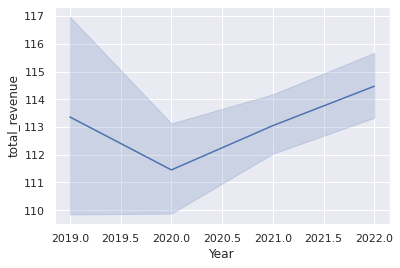

In [51]:
sns.lineplot(x=data.groupby(data.index).mean()['Year'],
             y=data.groupby(data.index).mean()['total_revenue'])

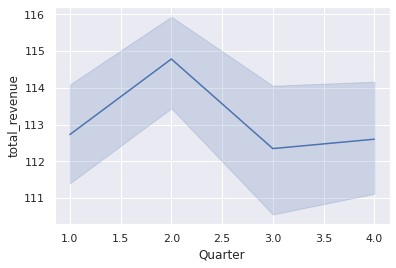

In [52]:
sns.lineplot(x=data.groupby(data.index).mean()['Quarter'],
             y=data.groupby(data.index).mean()['total_revenue'])

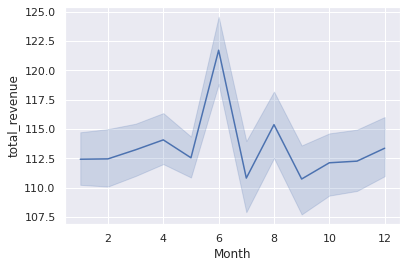

In [53]:
sns.lineplot(x=data.groupby(data.index).mean()['Month'],
             y=data.groupby(data.index).mean()['total_revenue'])

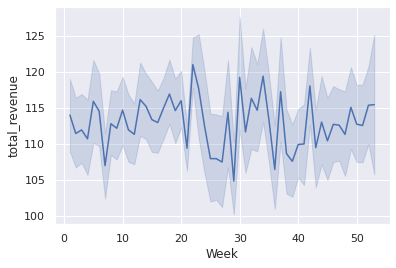

In [54]:
sns.lineplot(x=data.groupby(data.index).mean()['Week'],
             y=data.groupby(data.index).mean()['total_revenue'])

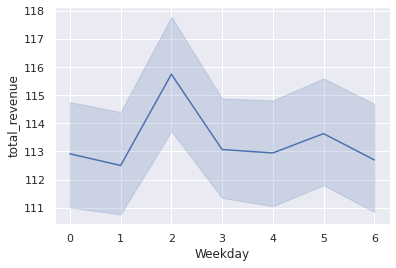

In [55]:
sns.lineplot(x=data.groupby(data.index).mean()['Weekday'],
             y=data.groupby(data.index).mean()['total_revenue'])

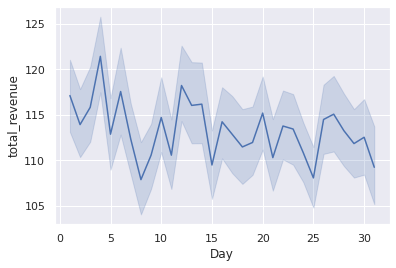

In [56]:
sns.lineplot(x=data.groupby(data.index).mean()['Day'],
             y=data.groupby(data.index).mean()['total_revenue'])

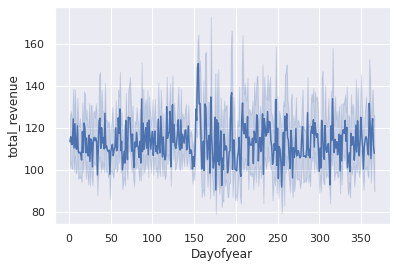

In [57]:
sns.lineplot(x=data.groupby(data.index).mean()['Dayofyear'],
             y=data.groupby(data.index).mean()['total_revenue'])

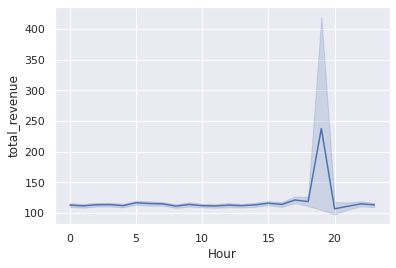

In [58]:
sns.lineplot(x=data.groupby(data.index).mean()['Hour'],
             y=data.groupby(data.index).mean()['total_revenue'])

# 3. Modelling with Prophet

In [253]:
! pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
from fbprophet import Prophet

In [255]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [256]:
plt.style.use('fivethirtyeight') # for plots

### Focus on daily product sales

#### As we like to product the daily amount of product sales, we need to compute a daily aggregation of this data. FOr this purpose we need to extract temporal features out of the created_at.

So, we have to split our data into train-test data to be able to tain our model and validate its capabilities.

In [257]:
data.Date.min()

Timestamp('2019-01-05 00:00:00')

In [258]:
data.Date.max()

Timestamp('2022-06-06 00:00:00')

In [259]:
data.head()

,order_id,user_id,product_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,gender,...,profit,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Hour,Date
0,44006,35515,13606,1,2021-01-21 04:56:58,2021-01-19 07:16:00,2021-01-22 03:38:00,0,2.5,0,...,4.1775,2021,1,1,3,3,21,21,4,2021-01-21
1,59418,47846,13606,0,2022-05-22 11:36:45,0,0,0,2.5,0,...,2.7850,2022,2,5,20,6,22,142,11,2022-05-22
2,27384,22099,28951,4,2022-02-12 14:40:47,2022-02-15 04:48:00,0,0,3.0,1,...,6.9240,2022,1,2,6,5,12,43,14,2022-02-12
3,98658,79128,28951,3,2021-11-02 02:32:52,2021-11-02 12:34:00,2021-11-06 20:31:00,2021-11-07 19:31:00,3.0,1,...,3.4620,2021,4,11,44,1,2,306,2,2021-11-02
4,105326,84559,28951,3,2021-10-12 07:11:30,2021-10-13 00:10:00,2021-10-14 01:20:00,2021-10-16 02:38:00,3.0,1,...,5.1930,2021,4,10,41,1,12,285,7,2021-10-12


In [260]:
def create_features(data, label=None):
  X = data[["Year", "Quarter", "Month", "Week", "Weekday",
            "Day", "Dayofyear", "Hour"]]
  if label:
    y = data[label]
    return X, y
  return X

X, y = create_features(data, label='total_revenue')

features_and_target = pd.concat([X, y], axis=1)

In [261]:
# See our features and target
features_and_target.head()

,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Hour,total_revenue
0,2021,1,1,3,3,21,21,4,7.5
1,2022,2,5,20,6,22,142,11,5.0
2,2022,1,2,6,5,12,43,14,12.0
3,2021,4,11,44,1,2,306,2,6.0
4,2021,4,10,41,1,12,285,7,9.0


In [262]:
features_and_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180353 entries, 0 to 180507
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           180353 non-null  int64  
 1   Quarter        180353 non-null  int64  
 2   Month          180353 non-null  int64  
 3   Week           180353 non-null  int64  
 4   Weekday        180353 non-null  int64  
 5   Day            180353 non-null  int64  
 6   Dayofyear      180353 non-null  int64  
 7   Hour           180353 non-null  int64  
 8   total_revenue  180353 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 13.8 MB


In [263]:
# Create sales table for forecasting
sales = data.loc[:, {'Date': 'ds',
                    'total_revenue': 'y'}]
sales = sales.set_index(['Date'])
sales = sales.sort_index()
sales = sales.groupby('Date').sum()

In [264]:
sales.head()

,total_revenue
Date,
2019-01-05,159.899994
2019-01-08,36.000000
2019-01-10,93.239998
2019-01-12,22.000000
2019-01-13,116.789999


In [265]:
sales.tail()

,total_revenue
Date,
2022-06-02,146609.880273
2022-06-03,103733.400129
2022-06-04,77055.860282
2022-06-05,30002.540023
2022-06-06,15828.109980


In [266]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2019-01-05 to 2022-06-06
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_revenue  1237 non-null   float64
dtypes: float64(1)
memory usage: 19.3 KB


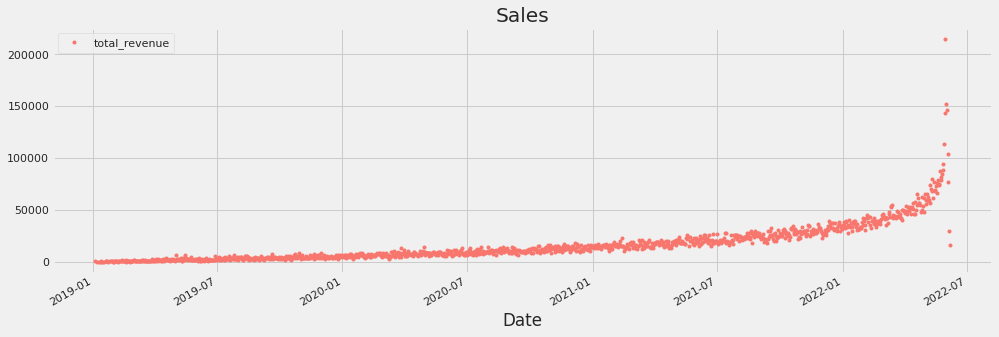

In [267]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
sales.plot(style='.', figsize=(15,5), color=color_pal[0], title='Sales')
plt.show()

## Train/Test Split

In [268]:
sales.index.min()

Timestamp('2019-01-05 00:00:00')

In [269]:
sales.index.max()

Timestamp('2022-06-06 00:00:00')

In [270]:
train_size = int(len(sales.index) * 0.8)
train, test = sales[0:train_size], sales[train_size:len(sales.index)]

print('The length of observation is', len(sales.index))
print('The length of training set is', len(train))
print('The length of test set is', len(test))

The length of observation is 1237
The length of training set is 989
The length of test set is 248


In [271]:
split_date = sales.index[989]
split_date

Timestamp('2021-10-02 00:00:00')

In [272]:
sales_train = sales.loc[sales.index <= split_date].copy()
sales_test = sales.loc[sales.index > split_date].copy()

print('The length of training set is', len(sales_train))
print('The length of test set is', len(sales_test))

The length of training set is 990
The length of test set is 247


In [273]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 990 entries, 2019-01-05 to 2021-10-02
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_revenue  990 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB


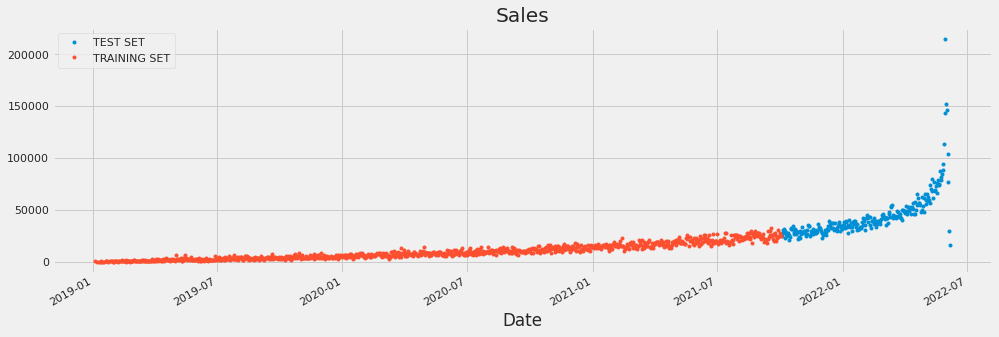

In [274]:
# Plot train and test so you can see where we have split
sales_test \
    .rename(columns={'total_revenue': 'TEST SET'}) \
    .join(sales_train.rename(columns={'total_revenue': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Sales', style='.')
plt.show()

## Prophet Modelling

In [275]:
# Format data for prophet model using ds and y
sales_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'total_revenue':'y'}).head()

,ds,y
0,2019-01-05,159.899994
1,2019-01-08,36.000000
2,2019-01-10,93.239998
3,2019-01-12,22.000000
4,2019-01-13,116.789999


In [276]:
# Setup and train model and fit
model = Prophet(interval_width=0.95)
model.fit(sales.reset_index() \
              .rename(columns={'Date':'ds',
                               'total_revenue':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [277]:
# Predict on training set with model
sales_test_fcst = model.predict(df=sales_test.reset_index() \
                                   .rename(columns={'Date':'ds'}))

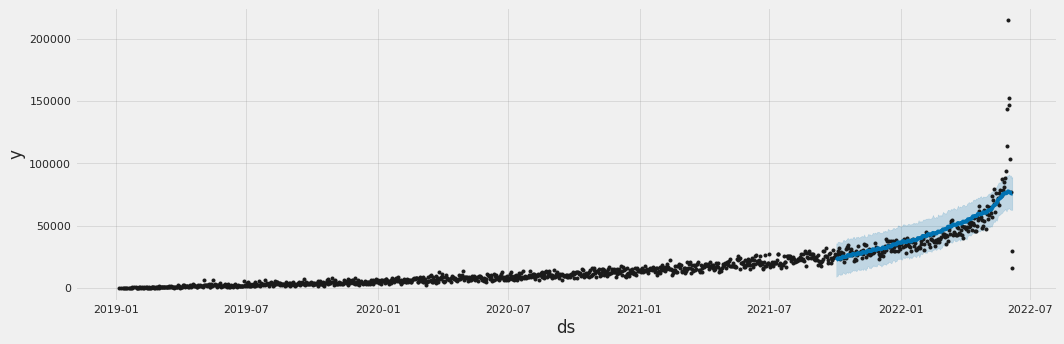

In [278]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(sales_test_fcst,
                 ax=ax)
plt.show()

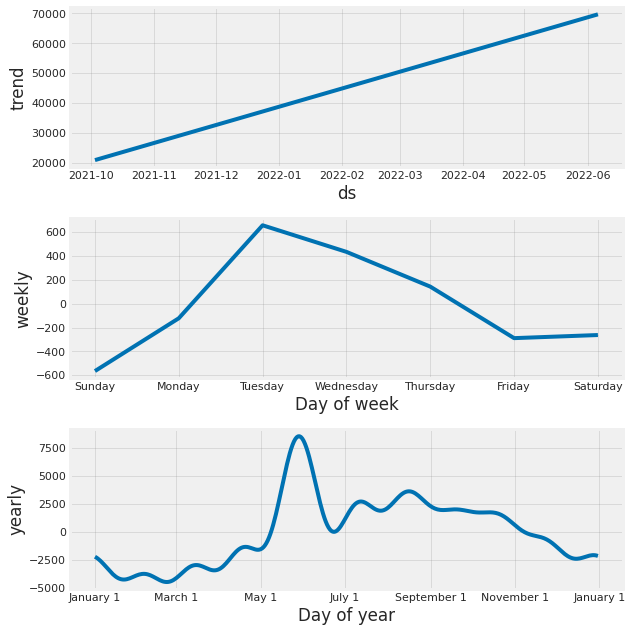

In [279]:
# Plot the components of the model
fig = model.plot_components(sales_test_fcst)

### Compare Forecast to Actuals

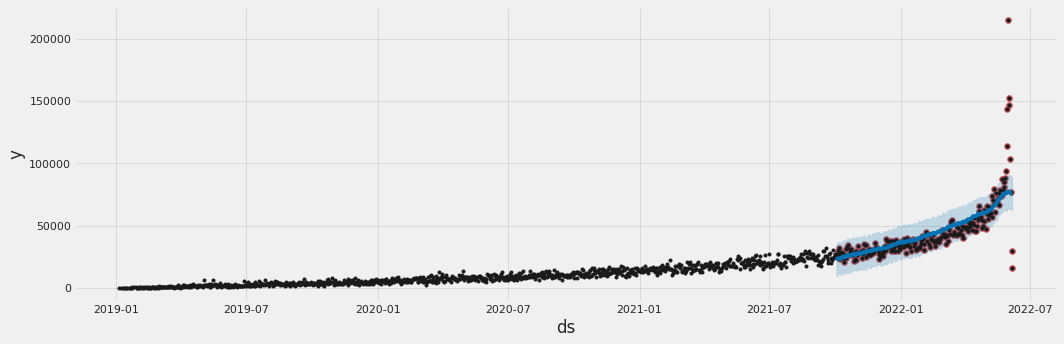

In [280]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(sales_test.index, sales_test['total_revenue'], color='r')
fig = model.plot(sales_test_fcst, ax=ax)

Black dots: Actuals train set, 
Red dots: Actuals test set, 
Blue line: Forecast test set



In [281]:
# dataframe that extends into future 12 months
future_dates = model.make_future_dataframe(periods = 12, freq='M')
print('First week to forecast.')
future_dates.tail()

First week to forecast.


,ds
1244,2023-01-31
1245,2023-02-28
1246,2023-03-31
1247,2023-04-30
1248,2023-05-31


In [282]:
future_dates.head()

,ds
0,2019-01-05
1,2019-01-08
2,2019-01-10
3,2019-01-12
4,2019-01-13


In [283]:
# predictions
forecast = model.predict(future_dates)

# predictions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1242,2022-11-30,104009.099903,87961.355424,120616.501332
1243,2022-12-31,108498.438699,91687.621882,125761.920688
1244,2023-01-31,113782.158533,94658.295315,133209.004088
1245,2023-02-28,119003.607654,98994.374955,139262.615868
1246,2023-03-31,125044.586155,101709.978207,148806.407784
1247,2023-04-30,132508.873003,104638.853717,159072.610388
1248,2023-05-31,149652.523926,118749.915549,178753.215870


In [284]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fc.head()

,ds,yhat
0,2019-01-05,2256.773685
1,2019-01-08,2710.273291
2,2019-01-10,1855.510142
3,2019-01-12,1109.925534
4,2019-01-13,644.577949


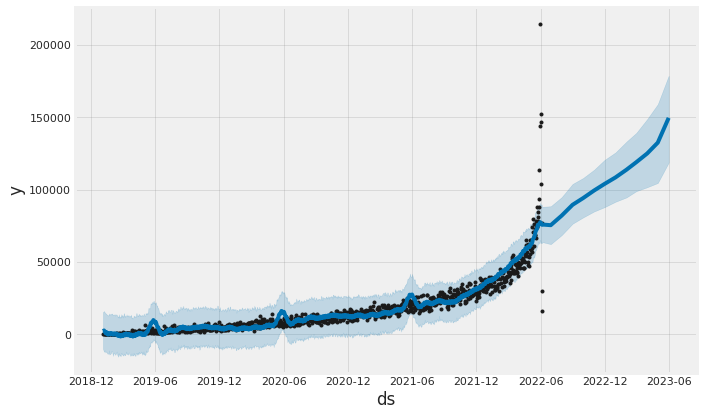

In [285]:
# visualizing predictions
sales_forecast = model.plot(forecast);

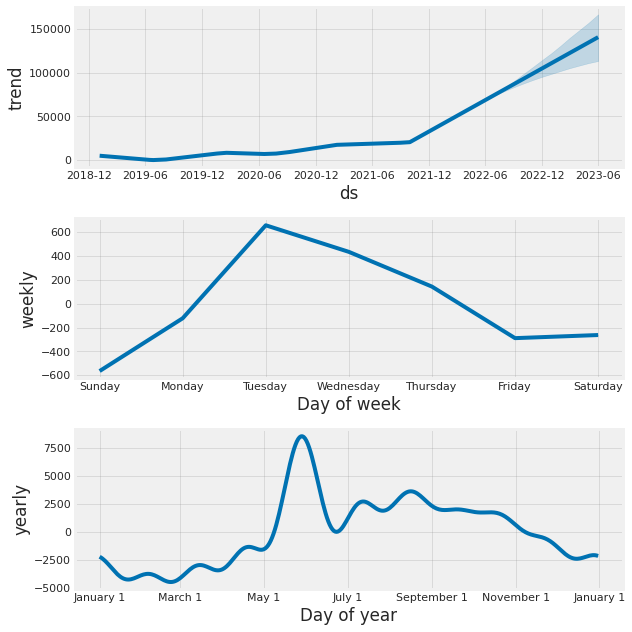

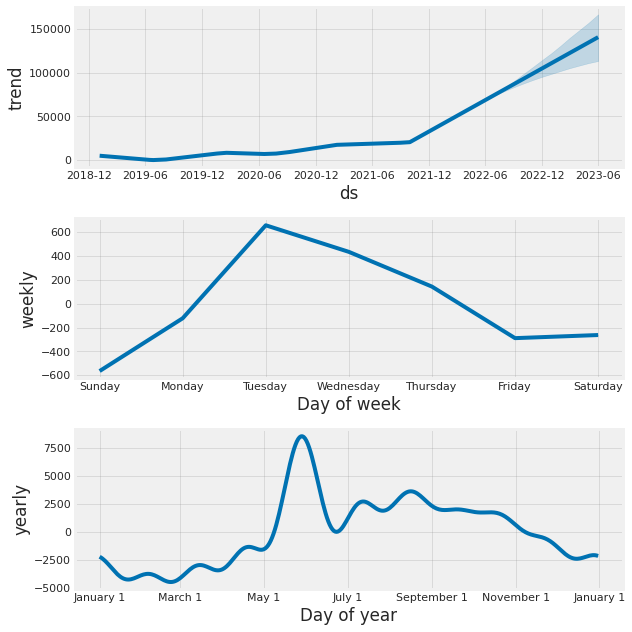

In [286]:
model.plot_components(forecast)

## Error Metrics

In [287]:
mean_squared_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test_fcst['yhat'])

197879717.82251814

In [288]:
mean_absolute_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test_fcst['yhat'])

6392.404671746005

In [289]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test_fcst['yhat'])

14.1871749554142

## Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [97]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=sales_train.index.min(),
                              end=sales_train.index.max())
test_holidays = cal.holidays(start=sales_test.index.min(),
                             end=sales_test.index.max())

In [98]:
# Create a dataframe with holiday, ds columns
sales.index = pd.to_datetime(sales.index)

In [99]:
sales['date'] = sales.index.date
sales['is_holiday'] = sales.date.isin([d.date() for d in cal.holidays()])
holiday_df = sales.loc[sales['is_holiday']] \
    .reset_index() \
    .rename(columns={'Date':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['total_revenue','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2019-01-21,USFederalHoliday
1,2019-02-18,USFederalHoliday
2,2019-05-27,USFederalHoliday
3,2019-07-04,USFederalHoliday
4,2019-09-02,USFederalHoliday


In [100]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(sales_train.reset_index() \
                            .rename(columns={'Date':'ds',
                                             'total_revenue':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predict with Holidays

In [101]:
# Predict on training set with model
sales_test_fcst_with_hols = \
    model_with_holidays.predict(df=sales_test.reset_index() \
                                    .rename(columns={'Date':'ds'}))

### Plot Holiday Effect

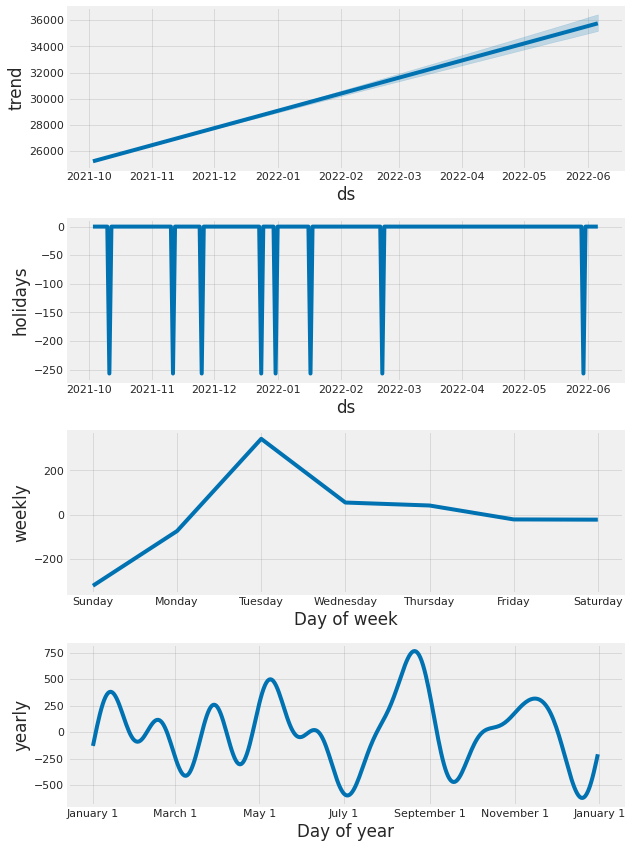

In [102]:
fig2 = model_with_holidays.plot_components(sales_test_fcst_with_hols)

### Error Metrics Holiday Added

In [103]:
mean_squared_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test_fcst_with_hols['yhat'])

587781822.5073729

In [104]:
mean_absolute_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test_fcst_with_hols['yhat'])

13873.628054634655

In [105]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test_fcst_with_hols['yhat'])

24.308589519402084

The error getting worse, when the holiday is added.

### Cross Validation

In [106]:
from fbprophet.diagnostics import cross_validation

In [107]:
sales.shape

(1237, 3)

In [151]:
cv = cross_validation(model, initial='900 days', period='90 days', horizon='30 days')

INFO:fbprophet:Making 4 forecasts with cutoffs between 2021-08-10 00:00:00 and 2022-05-07 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

In [152]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-08-11,22406.957559,18900.624705,26098.001730,23063.090015,2021-08-10
1,2021-08-12,22365.448562,18762.317856,25723.780764,22287.520009,2021-08-10
2,2021-08-13,22272.261706,18785.065010,25509.954464,24821.130022,2021-08-10
3,2021-08-14,22357.804204,19073.560661,25858.807081,27553.400013,2021-08-10
4,2021-08-15,22056.252362,18645.691045,25808.510305,24382.359982,2021-08-10


### Performance Metrics

In [153]:
from fbprophet.diagnostics import performance_metrics

In [154]:
sales_pm = performance_metrics(cv)

In [155]:
sales_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,6.991148e+07,8361.308694,5423.160388,0.107210,0.076048,0.666667
1,4 days,1.331754e+08,11540.166281,8478.446065,0.162813,0.174123,0.333333
2,5 days,1.155332e+08,10748.638487,8186.983552,0.169205,0.188381,0.333333
3,6 days,9.382651e+07,9686.408543,7108.127256,0.150454,0.141281,0.416667
4,7 days,7.545464e+07,8686.462829,6056.140733,0.127403,0.116031,0.583333
5,8 days,7.329010e+07,8560.963443,5492.179900,0.108597,0.073894,0.666667
6,9 days,8.859546e+07,9412.516330,6160.836326,0.114653,0.064837,0.583333
7,10 days,7.639675e+07,8740.523619,5941.231323,0.115866,0.072828,0.583333
8,11 days,7.225467e+07,8500.274992,5977.721885,0.130696,0.108399,0.500000
9,12 days,9.516032e+07,9755.014957,6864.231776,0.150829,0.141956,0.500000


### Visualizing Performance Metrics

In [156]:
from fbprophet.plot import plot_cross_validation_metric

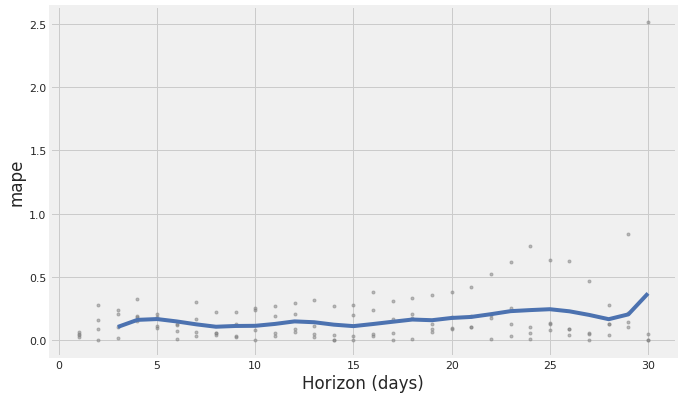

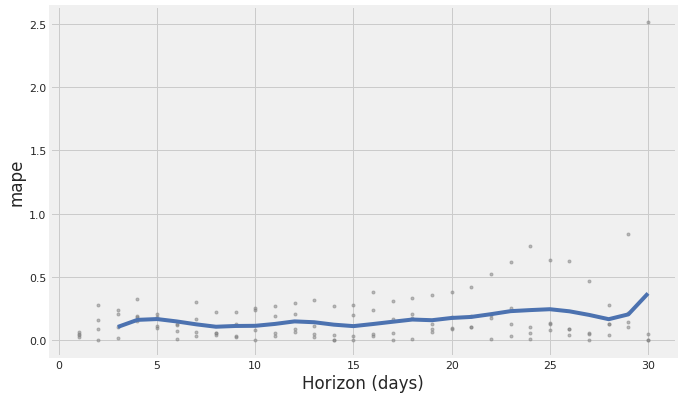

In [157]:
plot_cross_validation_metric(cv,metric='mape')

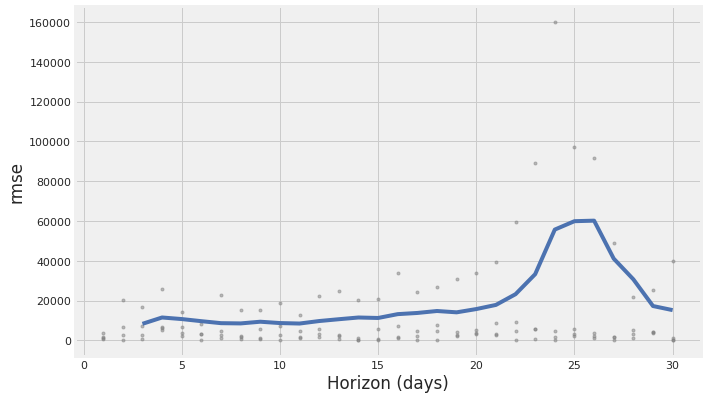

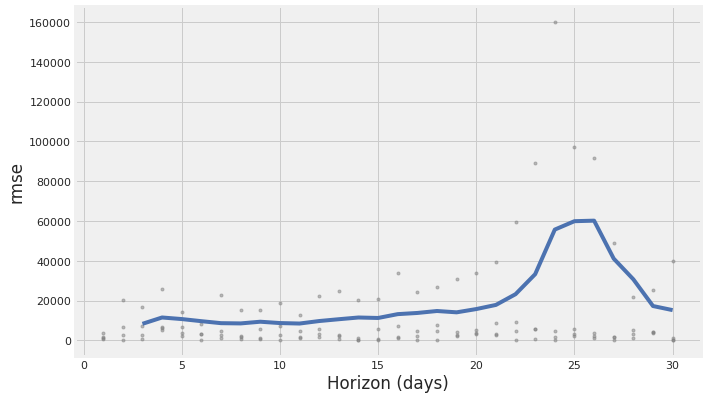

In [158]:
plot_cross_validation_metric(cv,metric='rmse')

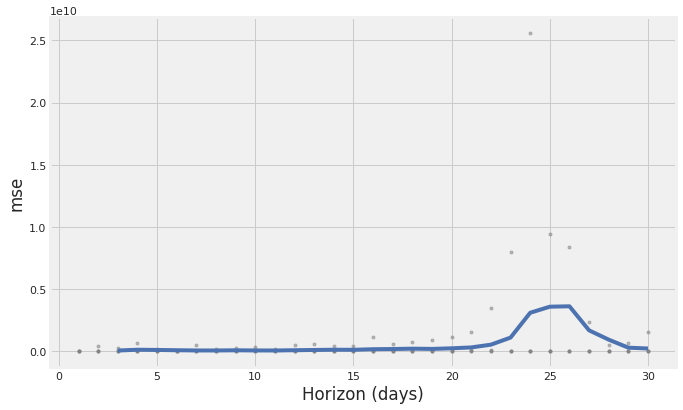

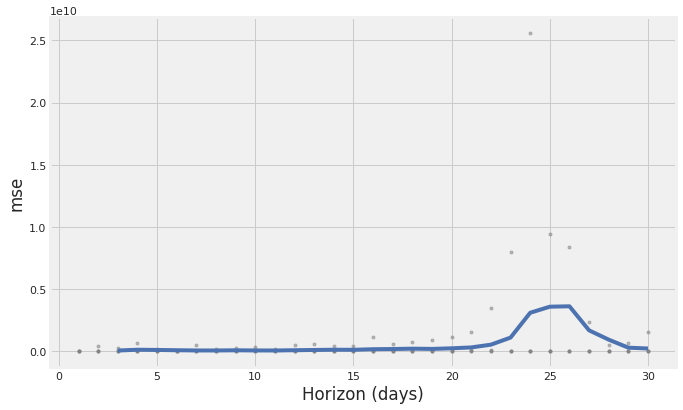

In [159]:
plot_cross_validation_metric(cv,metric='mse')

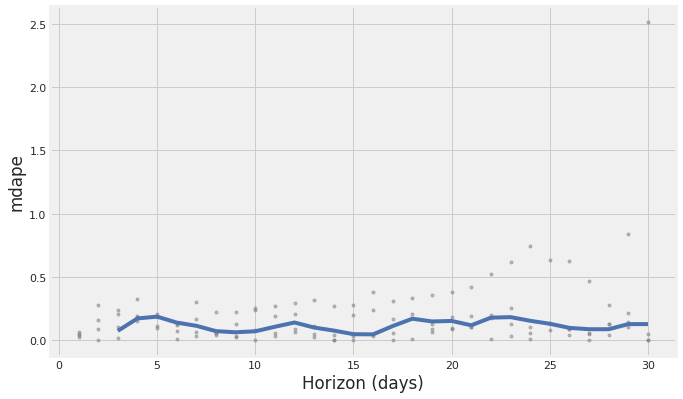

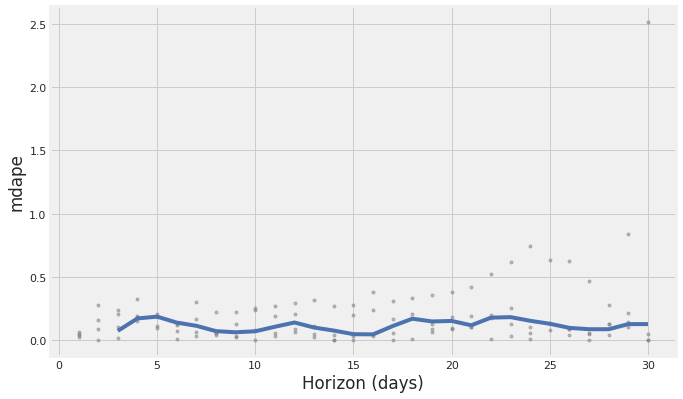

In [160]:
plot_cross_validation_metric(cv,metric='mdape')

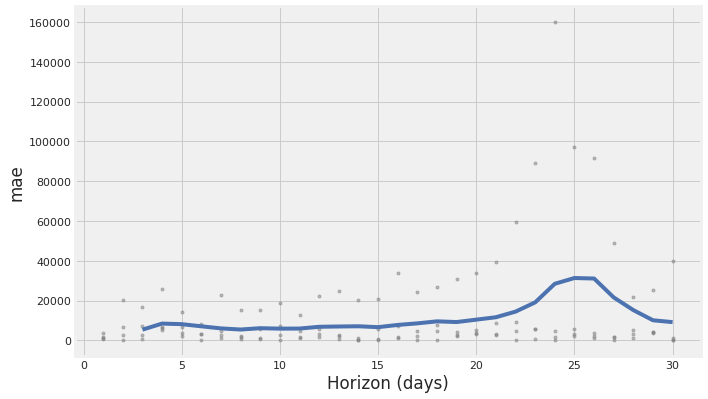

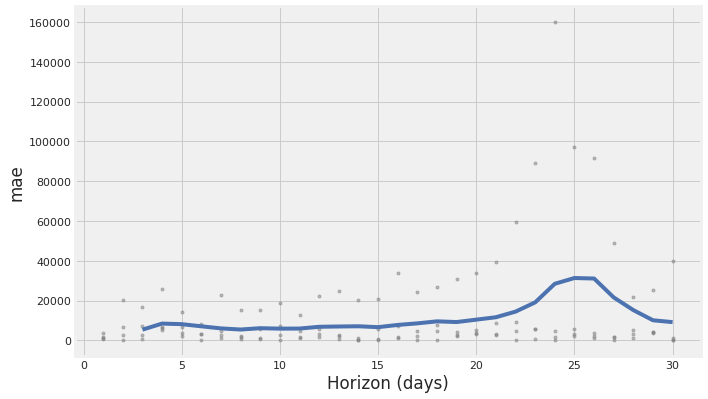

In [161]:
plot_cross_validation_metric(cv,metric='mae')

# Modelling with XGBoost

In [162]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [163]:
sales = data.loc[:, {'Date': 'ds',
                    'total_revenue': 'y'}]
sales = sales.set_index(['Date'])
sales = sales.sort_index()
sales = sales.groupby('Date').sum()
sales

,total_revenue
Date,
2019-01-05,159.899994
2019-01-08,36.000000
2019-01-10,93.239998
2019-01-12,22.000000
2019-01-13,116.789999
...,...
2022-06-02,146609.880273
2022-06-03,103733.400129
2022-06-04,77055.860282


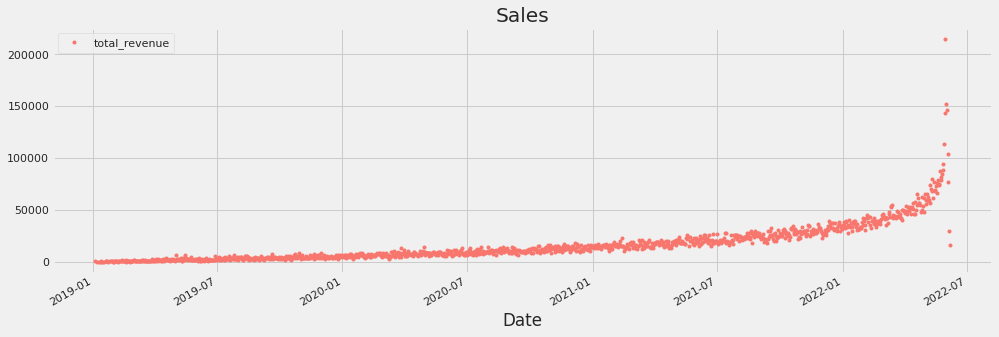

In [164]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
sales.plot(style='.', figsize=(15,5), color=color_pal[0], title='Sales')
plt.show()

### Train/Test Split

In [165]:
train_size = int(len(sales.index) * 0.8)
train, test = sales[0:train_size], sales[train_size:len(sales.index)]

print('The length of observation is', len(sales.index))
print('The length of training set is', len(train))
print('The length of test set is', len(test))

The length of observation is 1237
The length of training set is 989
The length of test set is 248


In [166]:
split_date = sales.index[989]
split_date

Timestamp('2021-10-02 00:00:00')

In [167]:
sales_train = sales.loc[sales.index <= split_date].copy()
sales_test = sales.loc[sales.index].copy()

print('The length of training set is', len(sales_train))
print('The length of test set is', len(sales_test))

The length of training set is 990
The length of test set is 1237


In [168]:
sales_train.head()

,total_revenue
Date,
2019-01-05,159.899994
2019-01-08,36.000000
2019-01-10,93.239998
2019-01-12,22.000000
2019-01-13,116.789999


In [169]:
sales_test.head()

,total_revenue
Date,
2019-01-05,159.899994
2019-01-08,36.000000
2019-01-10,93.239998
2019-01-12,22.000000
2019-01-13,116.789999


In [172]:
def create_features(data, label=None):
  """
  Create time series features from datetime index
  """
  data["Date"] = data.index
  data["Year"] = data["Date"].dt.year
  data["Quarter"] = data["Date"].dt.quarter
  data["Month"] = data["Date"].dt.month
  data["Week"] = data["Date"].dt.week
  data["Weekday"] = data["Date"].dt.weekday
  data["Day"] = data["Date"].dt.day
  data["Dayofyear"] = data["Date"].dt.dayofyear
  data["Hour"] = data["Date"].dt.hour
  
  X = data[["Hour", "Quarter", "Month", "Year", "Dayofyear", 
            "Week", "Weekday", "Day"]]
  if label:
    y = data[label]
    return X, y
  return X

In [173]:
X_train, y_train = create_features(sales_train, label='total_revenue')
X_test, y_test = create_features(sales_test, label='total_revenue')

### XGBoost Modelling

In [174]:
reg = xgb.XGBRegressor(n_estimators=1000, max_depth=6, eta=0.1, subsample=0.7, colsample_bytree=0.8, learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=10,
        verbose=False) # Change verbose to True if you want to see it train

[06:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=1000,
             subsample=0.7)

In [176]:
score = reg.score(X_train, y_train)
print("Training score: ", score)

Training score:  0.9803750697084056


In [177]:
scores = cross_val_score(reg, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

[06:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [178]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

[06:56:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Plot Feature Importance

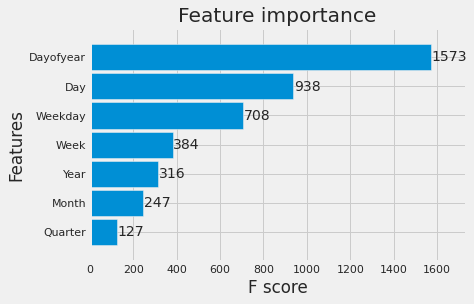

In [175]:
feature_importance = plot_importance(reg, height=0.9)

#### Forecast on Test Set

In [197]:
sales_test['sales_prediction'] = reg.predict(X_test)

In [198]:
sales_all = pd.concat([sales_test, sales_train], sort=False)

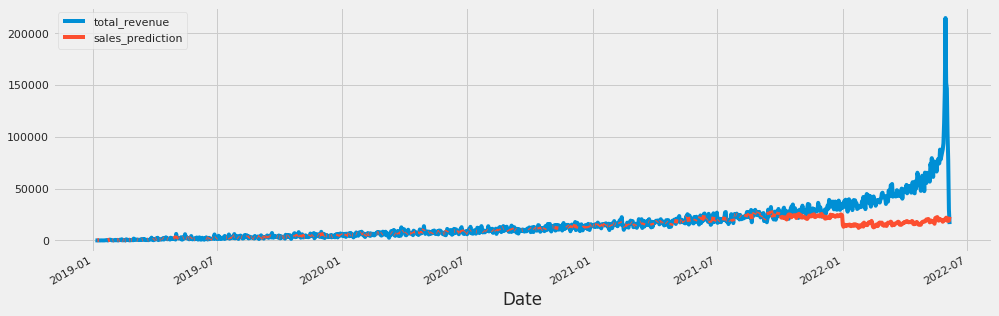

In [181]:
sales_plot = sales_all[['total_revenue', 'sales_prediction']].plot(figsize=(15,5))

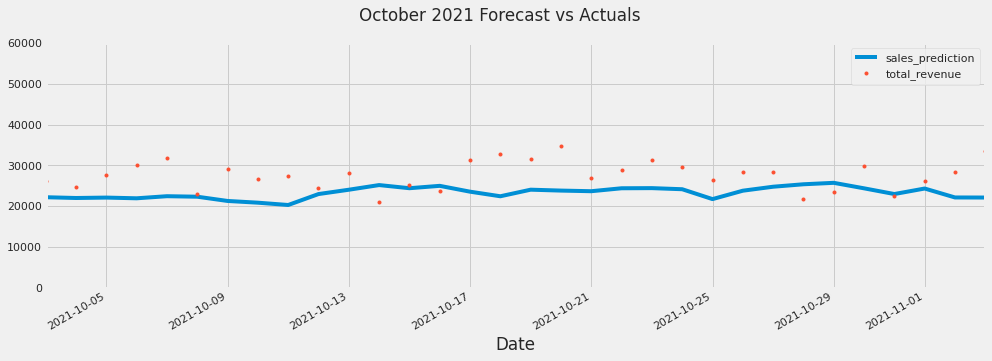

In [182]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
sales_plot1 = sales_all[['sales_prediction','total_revenue']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='10-03-2021', upper='11-03-2021')
ax.set_ylim(0, 60000)
plot = plt.suptitle('October 2021 Forecast vs Actuals')

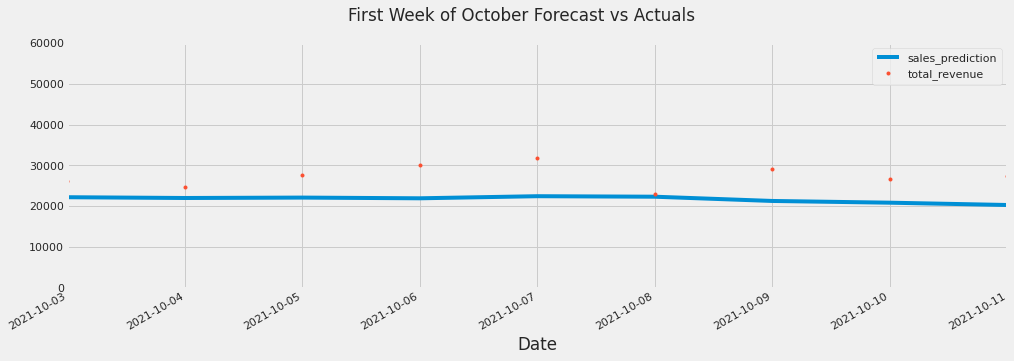

In [183]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
sales_plot2 = sales_all[['sales_prediction','total_revenue']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='10-03-2021', upper='10-11-2021')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of October Forecast vs Actuals')

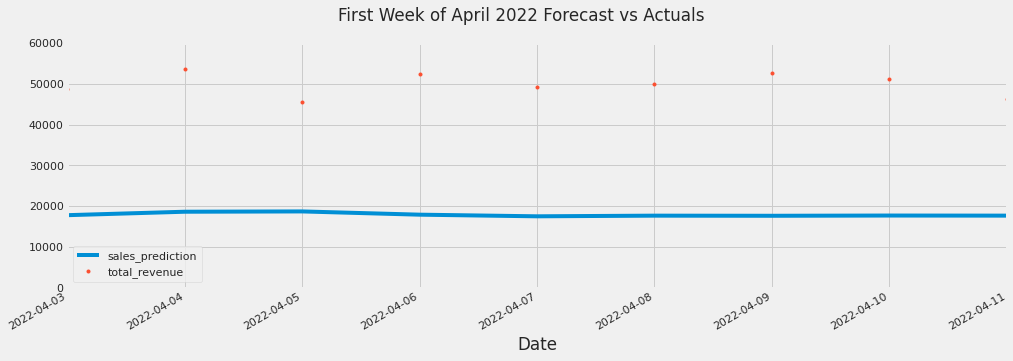

In [184]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
sales_plot3 = sales_all[['sales_prediction','total_revenue']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='04-03-2022', upper='04-11-2022')
plot = plt.suptitle('First Week of April 2022 Forecast vs Actuals')

### Error Metrics on Test Set

In [185]:
mean_squared_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test['sales_prediction'])

229295369.4091572

In [186]:
mean_absolute_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test['sales_prediction'])

5569.233837816825

In [187]:
mean_absolute_percentage_error(y_true=sales_test['total_revenue'],
                   y_pred=sales_test['sales_prediction'])

26.7327426130485

### Look at Worst and Best Predicted Days

In [188]:
sales_test['error'] = sales_test['total_revenue'] - sales_test['sales_prediction']
sales_test['abs_error'] = sales_test['error'].apply(np.abs)
error_by_day = sales_test.groupby(['Year','Month','Day']) \
    .mean()[['total_revenue','sales_prediction','error','abs_error']]

In [189]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

total_revenue  sales_prediction        error    abs_error
Year Month Day                                                           
2022 6     6     15828.109980      22933.826172 -7105.716192  7105.716192
2021 10    14    20930.480037      25170.304688 -4239.824651  4239.824651
           28    21759.680012      25365.435547 -3605.755535  3605.755535
     8     21    17592.640089      20753.406250 -3160.766161  3160.766161
2020 8     13     6368.280010       9425.625977 -3057.345967  3057.345967
     10    6      8176.020029      11125.878906 -2949.858877  2949.858877
2021 9     25    20026.000044      22930.476562 -2904.476519  2904.476519
     8     19    21861.209978      24669.222656 -2808.012678  2808.012678
     5     21    15397.930008      18028.939453 -2631.009445  2631.009445
     12    1     23024.300106      25647.265625 -2622.965519  2622.965519

Over forecasted days:
1. June 6th 2022
2. October 14th 2021

In [190]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

total_revenue  sales_prediction          error      abs_error
Year Month Day                                                               
2022 5     31   214734.160040      20411.837891  194322.322149  194322.322149
     6     1    152208.660175      22036.515625  130172.144550  130172.144550
           2    146609.880273      19251.269531  127358.610742  127358.610742
     5     30   143819.800054      20526.351562  123293.448492  123293.448492
           29   113592.230200      19379.464844   94212.765357   94212.765357
     6     3    103733.400129      19247.599609   84485.800520   84485.800520
     5     28    93770.740005      19862.460938   73908.279067   73908.279067
           27    87970.080100      18092.875000   69877.205100   69877.205100
           23    87719.130000      20128.916016   67590.213985   67590.213985
           26    84725.050092      19269.046875   65456.003217   65456.003217

In [191]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

total_revenue  sales_prediction      error  abs_error
Year Month Day                                                       
2021 1     12    15420.099971      15421.771484  -1.671513   1.671513
2020 6     21     8309.359982       8305.699219   3.660764   3.660764
2021 6     16    20359.230079      20367.335938  -8.105859   8.105859
2019 1     5       159.899994        151.780365   8.119629   8.119629
           13      116.789999        106.087196  10.702803  10.702803
           26      829.940006        817.187012  12.752995  12.752995
2020 9     6     10982.500045      10995.720703 -13.220658  13.220658
2019 7     1      2750.759995       2734.076172  16.683824  16.683824
     2     15      174.949997        156.851913  18.098083  18.098083
2020 4     17     6903.980001       6923.370117 -19.390116  19.390116

The best predicted days seem to be a lot of in October. 

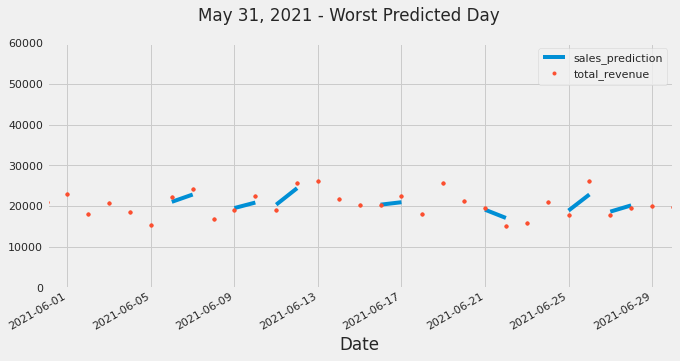

In [192]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
error_plot = sales_all[['sales_prediction','total_revenue']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-31-2021', upper='06-30-2021')
plot = plt.suptitle('May 31, 2021 - Worst Predicted Day')

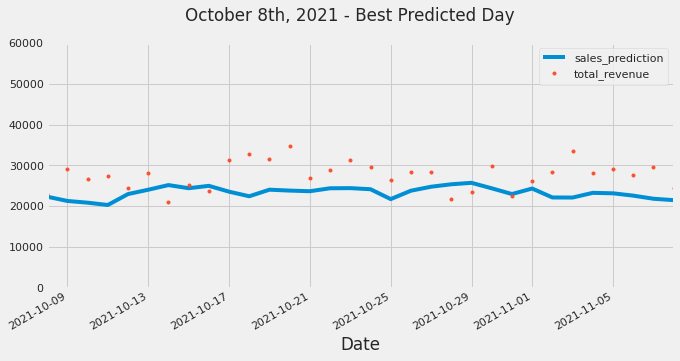

In [193]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
best_predicted_day = sales_all[['sales_prediction','total_revenue']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-08-2021', upper='11-08-2021')
plot = plt.suptitle('October 8th, 2021 - Best Predicted Day')

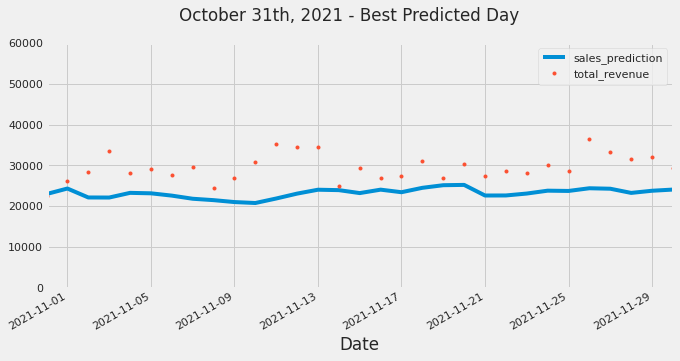

In [194]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
best_predicted_day = sales_all[['sales_prediction','total_revenue']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-31-2021', upper='11-30-2021')
plot = plt.suptitle('October 31th, 2021 - Best Predicted Day')

# Conclusion

Based on Modelling forecast using XGBoost and Prophet. We can conclude that Prophet modelling is way better than XGBoost. As we can see that Prophet MAPE score is: 14.18%, while XGBoost MAPE is: 26.73%.

Therefore, the valid forecast for The Look Sales Prediction is forecast using Prophet.